In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import roc_auc_score as rs
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pylab as plt

%matplotlib inline

In [81]:
df = pd.read_csv('merged_data_1.1.csv', index_col=0)

In [62]:
df.head()

,id,BoroCT2010,n_report,DBN,school_distance,n_school,subway_distance,n_tobacco,Enrollment,Student Achievement Rating,...,Percent Hispanic,Percent Asian,% Female,% Poverty,MHI,Total Population,type,latitude,longitude,have_sold
0,19157,5000900,0.0,24Q600,2826.764130,0.0,79.859155,3,1575,Approaching Target,...,0.757,0.112,0.377778,0.811429,56192,2112,GROCERY SUPERMARKET,40.640561,-74.082207,0
1,18026,5000900,0.0,10X225,1703.127328,1.0,924.970954,3,427,Approaching Target,...,0.700,0.009,0.674603,1.000000,56192,2112,CONVENIENCE STORE,40.641998,-74.078975,0
2,12113,5000900,0.0,28Q690,2929.402252,0.0,5998.612261,3,589,Approaching Target,...,0.195,0.104,0.463497,0.728353,56192,2112,GROCERY SUPERMARKET,40.640561,-74.082207,0
3,13601,5007400,0.0,15K448,1740.529846,0.0,2489.816362,2,415,Exceeding Target,...,0.422,0.046,0.508100,0.684831,65559,4693,GROCERY SUPERMARKET,40.591647,-74.067662,0
4,10482,5007400,0.0,23K493,630.587028,0.0,941.382096,2,307,Meeting Target,...,0.114,0.010,0.387622,0.856678,65559,4693,GROCERY SUPERMARKET,40.595713,-74.063245,0


In [82]:
df.dtypes

id                              int64
BoroCT2010                      int64
n_report                      float64
DBN                            object
school_distance               float64
n_school                      float64
subway_distance               float64
n_tobacco                       int64
Enrollment                      int64
Student Achievement Rating     object
Percent White                 float64
Percent Black                 float64
Percent Hispanic              float64
Percent Asian                 float64
% Female                      float64
% Poverty                     float64
MHI                             int64
Total Population                int64
type                           object
latitude                      float64
longitude                     float64
have_sold                       int64
dtype: object

In [63]:
#df.dropna(how='any', inplace=True)

In [83]:
achievement = {
    'Not Meeting Target':1,
    'Approaching Target':2,
    'Meeting Target':3,
    'Exceeding Target':4
}

def createdummies(series, col = None):
    cat_map = {}
    i = 0
    for status in series.unique():
        cat_map[status] = i
        i+=1
    for i in cat_map.iteritems():
        series.replace(i[0], i[1], inplace = True)
    return series, cat_map

In [84]:
#df['Achievement'] = df['Student Achievement Rating'].map(achievement)
df['Achievement']=createdummies(df['Student Achievement Rating'])[0]

In [85]:
df = df.dropna()
df.head()

,id,BoroCT2010,n_report,DBN,school_distance,n_school,subway_distance,n_tobacco,Enrollment,Student Achievement Rating,...,Percent Asian,% Female,% Poverty,MHI,Total Population,type,latitude,longitude,have_sold,Achievement
0,19157,5000900,0.0,24Q600,2826.764130,0.0,79.859155,3,1575,0,...,0.112,0.377778,0.811429,56192,2112,GROCERY SUPERMARKET,40.640561,-74.082207,0,0
1,18026,5000900,0.0,10X225,1703.127328,1.0,924.970954,3,427,0,...,0.009,0.674603,1.000000,56192,2112,CONVENIENCE STORE,40.641998,-74.078975,0,0
2,12113,5000900,0.0,28Q690,2929.402252,0.0,5998.612261,3,589,0,...,0.104,0.463497,0.728353,56192,2112,GROCERY SUPERMARKET,40.640561,-74.082207,0,0
3,13601,5007400,0.0,15K448,1740.529846,0.0,2489.816362,2,415,1,...,0.046,0.508100,0.684831,65559,4693,GROCERY SUPERMARKET,40.591647,-74.067662,0,1
4,10482,5007400,0.0,23K493,630.587028,0.0,941.382096,2,307,2,...,0.010,0.387622,0.856678,65559,4693,GROCERY SUPERMARKET,40.595713,-74.063245,0,2


### Binary Decision Tree

In [103]:
# Segmenting data for test train split
X = df[['school_distance','n_school','subway_distance','n_tobacco','Enrollment',
     'Percent White','Percent Black','Percent Hispanic','Percent Asian','% Female',
     '% Poverty','MHI','Total Population','Achievement']].copy()

X['school_distance']=pd.qcut(X['school_distance'],5, labels=False)
X['subway_distance']=pd.qcut(X['subway_distance'],5, labels=False)
X['Enrollment']=pd.qcut(X['Enrollment'],3, labels=False)
X['Percent White']=pd.qcut(X['Percent White'],3, labels=False)
X['Percent Black']=pd.qcut(X['Percent Black'],5, labels=False)
X['Percent Hispanic']=pd.qcut(X['Percent Hispanic'],5, labels=False)
X['Percent Asian']=pd.qcut(X['Percent Asian'],3, labels=False)
X['% Female']=pd.qcut(X['% Female'],5, labels=False)
X['% Poverty']=pd.qcut(X['% Poverty'],5, labels=False)
X['MHI']=pd.qcut(X['MHI'],5, labels=False)
X['Total Population']=pd.qcut(X['Total Population'],5, labels=False)

y = df['have_sold']

# #Splitting the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=2017)
X_train = X[3000:]
y_train = y[3000:]
X_test = X[:3000]
y_test = y[:3000]

# Here I categorized any other variables with qcut
# somehow it helps :|

### LEVELS:
# school distance:  [[8.984, 939.509] < (939.509, 1502.826] < (1502.826, 2197.0529] < (2197.0529, 3368.292] < (3368.292, 16567.442]]
# subway distance: [[10.179, 368.419] < (368.419, 794.261] < (794.261, 1311.238] < (1311.238, 2724.651] < (2724.651, 71490.762]]
# Enrollment: [[8, 342] < (342, 537] < (537, 5534]]
# percent white: [[0, 0.018] < (0.018, 0.095] < (0.095, 0.79]]
# percent black:[[0, 0.09] < (0.09, 0.216] < (0.216, 0.316] < (0.316, 0.626] < (0.626, 0.99]]
# percent hispanic:[[0.005, 0.176] < (0.176, 0.307] < (0.307, 0.513] < (0.513, 0.645] < (0.645, 1]]
# percent asian:[[0, 0.025] < (0.025, 0.098] < (0.098, 0.765]]
# female: [[0, 0.426] < (0.426, 0.475] < (0.475, 0.506] < (0.506, 0.577] < (0.577, 1]]
# poverty: [[0.177, 0.673] < (0.673, 0.738] < (0.738, 0.792] < (0.792, 0.884] < (0.884, 1]]
# MHI: [[0, 30164] < (30164, 39939] < (39939, 51710] < (51710, 71855] < (71855, 250001]]
# population: [[0, 2620] < (2620, 3673] < (3673, 4725] < (4725, 6372] < (6372, 26588]]

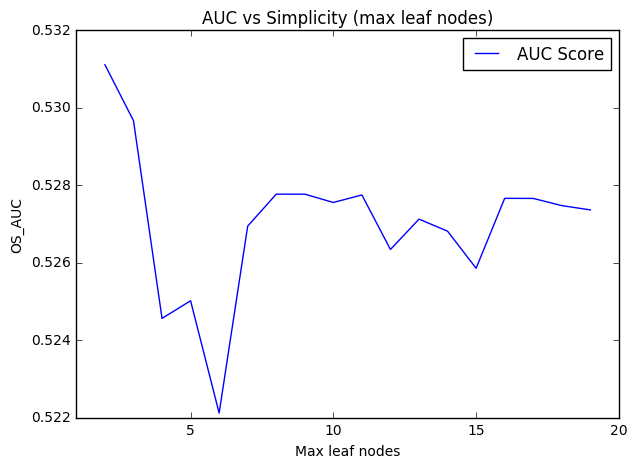

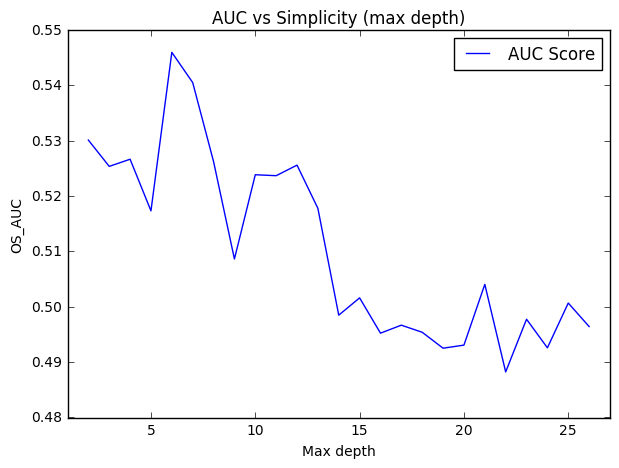

In [133]:
# function to create plot
def get_plot(X_train, y_train, X_test, y_test):
    # max leaf
    
    AUC=[]
    y_test = np.array(y_test.apply(int))
    for i in range(2,20,1):    
        classifier= DTC(max_leaf_nodes=i, random_state=2017)
        classifier.fit(X_train, y_train)
        pred=classifier.predict_proba(X_test)[:,1]
        AUC.append(rs(y_test,pred))

    plt.figure(figsize=(7,5))
    plt.plot(range(2,20,1),AUC,label='AUC Score')
    plt.xlabel("Max leaf nodes")
    plt.ylabel("OS_AUC")
    plt.title("AUC vs Simplicity (max leaf nodes)")
    plt.xlim(1,20)
    plt.legend()
    plt.show()
    
    # max depth
    AUC=[]
    dt = DTC().fit(X_train, y_train)
    md = dt.tree_.max_depth
    for i in range(2,md,1):    
        classifier= DTC(max_depth=i)
        classifier.fit(X_train, y_train)
        pred=classifier.predict_proba(X_test)[:,1]
        AUC.append(rs(y_test,pred))

    plt.figure(figsize=(7,5))
    plt.plot(range(2,md,1),AUC,label='AUC Score')
    plt.xlabel("Max depth")
    plt.ylabel("OS_AUC")
    plt.title("AUC vs Simplicity (max depth)")
    plt.xlim(1,md)
    plt.legend()
    plt.show()
    
get_plot(X_train, y_train, X_test, y_test)

In [147]:
# put max depth as parameter
maxdepth = 7
dt = DTC(max_depth=maxdepth, random_state=2017).fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = dt.score(X_test,y_test)
fscore = f1_score(y_test, y_pred, average="macro")
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")   

print "OS accuracy: " + str(accuracy)
print "OS precision: " + str(precision)
print "OS recall of: " + str(recall)
print "OS f1-score of: " + str(fscore)

OS accuracy: 0.840666666667
OS precision: 0.571237458194
OS recall of: 0.501778967097
OS f1-score of: 0.462869848195


In [135]:
#cross validation
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(dt, X, y, cv=10))

0.84707688822436678

In [148]:
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]
important_features_cont = Feature_importance.sort_values(by="importance",ascending=False).iloc[:5,:]
important_features_cont

,variables,importance
3,n_tobacco,0.168881
11,MHI,0.168077
2,subway_distance,0.125977
0,school_distance,0.0990679
12,Total Population,0.0625302


In [159]:
def get_metrics_with_small_attributes(X_train, important_features, max_depth=None, max_leaf=None):
    important_features = important_features.variables
    X_train_simple = X_train[important_features]
    X_test_simple = X_test[important_features]

    dt = DTC(max_depth=max_depth, max_leaf_nodes=max_leaf)
    dt.fit(X_train_simple, y_train)
    y_pred= dt.predict(X_test_simple)
    accuracy = dt.score(X_test_simple,y_test)
    fscore = f1_score(y_test, y_pred, average="macro")
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")   

    print "OS accuracy: " + str(accuracy)
    print "OS precision: " + str(precision)
    print "OS recall: " + str(recall)
    print "OS f1-score: " + str(fscore)

    return dt

print "Metrics with 5 attributes and max_depth = 5"
dt_small1 = get_metrics_with_small_attributes(X_train, important_features_cont, 5, None)
print ""
print "Metrics with 5 attributes and max_leaf_nodes = 8"
dt_small2 = get_metrics_with_small_attributes(X_train, important_features_cont, None, 8)

Metrics with 5 attributes and max_depth = 5
OS accuracy: 0.842333333333
OS precision: 0.707197747124
OS recall: 0.503625585055
OS f1-score: 0.46546404238

Metrics with 5 attributes and max_leaf_nodes = 8
OS accuracy: 0.842333333333
OS precision: 0.707197747124
OS recall: 0.503625585055
OS f1-score: 0.46546404238


In [175]:
#cross validation of precision
precs = []
for i in range(30):
    state = np.random.randint(5000)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = .3, random_state=state)
    y_pred=dt_small1.predict(X_test1[important_features_cont.variables])
    precision = precision_score(y_test1, y_pred, average="macro")
    precs.append(precision)
np.mean(precs)

0.73456616345521453

### DT with 5 attributes and max_depth =5 returns 70% of precision!!

TREE WITH MAX DEPTH = 5


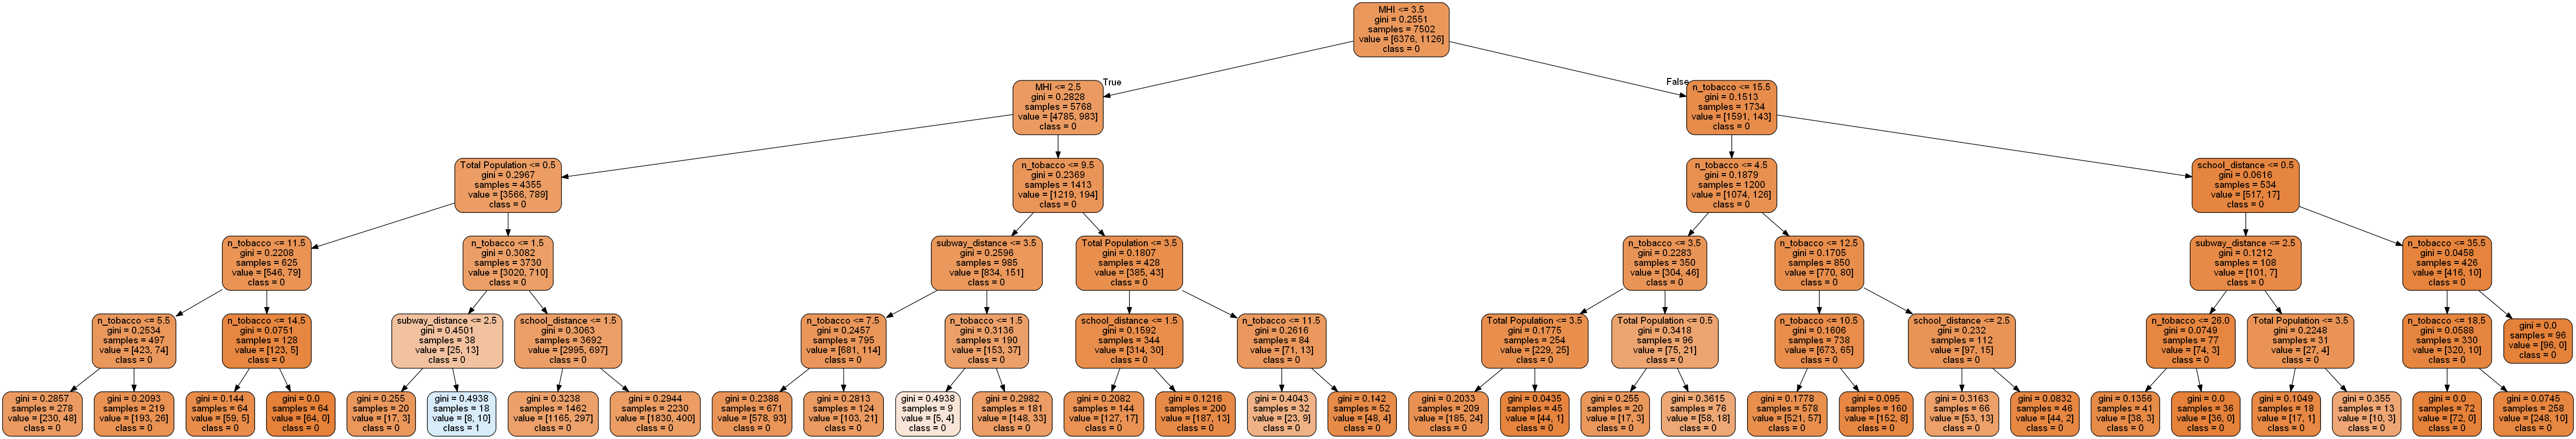

In [154]:
from sklearn.externals.six import StringIO  
from sklearn import tree
from IPython.display import Image  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(dt_small1, out_file=dot_data,  
                         feature_names=important_features_cont.variables.values,  
                         class_names=['0','1'],  
                         filled=True, rounded=True) 
                         #special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print "TREE WITH MAX DEPTH = 5"
Image(graph.create_png()) 

TREE WITH MAX LEAF = 8


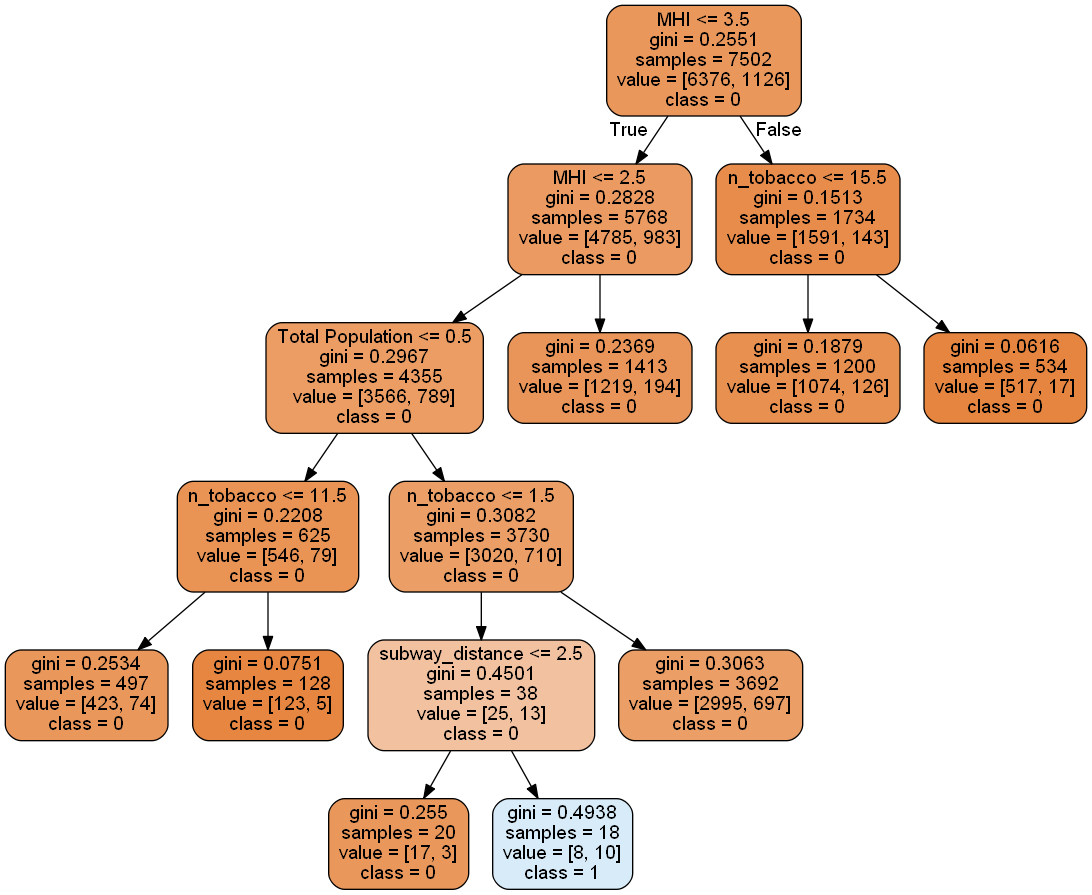

In [160]:
from sklearn.externals.six import StringIO  
from sklearn import tree
from IPython.display import Image  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(dt_small2, out_file=dot_data,  
                         feature_names=important_features_cont.variables.values,  
                         class_names=['0','1'],  
                         filled=True, rounded=True) 
                         #special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print "TREE WITH MAX LEAF = 8"
Image(graph.create_png())  